# Sentiment Analysis: Large Movie Review Dataset

Hi again! You will be expected to finish this on your own, but you can use the available channels on Discord to ask questions and help others. Please read the entire notebook before starting, this will give you a better idea of what you need to accomplish.

This project is related to NLP. As you may already know, the most important and hardest part of an NLP project is pre-processing, which is why we are going to focus on that.

### Getting the data

To access the data for this project, you only need to execute the code below. This will download three files:

- `movies_review_train_aai.csv`: Training dataset you must use to train and find the best hyperparameters on your model.

- `movies_review_test_aai.csv`: Test dataset to test your model.

Basically a basic sentiment analysis problem, as in this case, consists of a classification problem, where the possible output labels are: `positive` and `negative`. Which indicates, if the review of a movie speaks positively or negatively. In our case it is a binary problem, but one could have many more "feelings" tagged and thus allow a more granular analysis.

### These are the objectives of the project:

* Read data that is not in a traditional format.
* Put together a set of preprocessing functions that we can use later on any NLP or related problems.
* Vectorize the data in order to apply a machine learning model to it: using BoW or TF-IDF.
* BoW and TF-IDF are classic ways to vectorize text, but currently we have some more complex ways with better performance, for this we are going to train our own word embedding and use it as a vectorization source for our data.
* Train a sentiment analysis model that allows us to detect positive and negative opinions in movie reviews.

---
## 1. Get the data

**Download the data by executing the code below:**

`Notes:` Use the target column as `positive`, that way the positive value will be indicated with a value of `1` and negative with a value of `0`. In this case, a split train/test is not necessary because the original data is already separated.

In [1]:
from src import data_utils
import os
import sys
import numpy as np
from gensim.models import Word2Vec
import nltk
from imp import reload

sys.path.append(os.path.dirname(os.getcwd()))

from src import word2vec
from src import evaluation
from src import text_normalizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pickle

import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import (
    Input,
    Bidirectional,
    Dense,
    LSTM,
    Embedding
)
from keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)

train, test = data_utils.get_datasets()



C:\Users\user\AppData\Local\Temp\ipykernel_18092\3545458790.py:7: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# TODO Complete in this cell: Complete the function `split_data()` but not here in
# the notebook, do it in the python module called `data_utils.py`.
# Then make sure this code runs without errors.
X_train, y_train, X_test, y_test = data_utils.split_data(train, test)

In [3]:
stop_words = nltk.corpus.stopwords.words("english")

In [4]:
# TODO: Complete all the functions with the `TODO` comment inside the
# module `text_normalizer.py`. Then make sure this code runs without errors.
# You can change the parameters for `normalize_corpus()` if you want.
norm_train_reviews = text_normalizer.normalize_corpus(X_train, stopwords=stop_words,text_lemmatization= True)
norm_test_reviews = text_normalizer.normalize_corpus(X_test, stopwords=stop_words,text_lemmatization= True)
with open('norm_train_reviews_lem.pkl','wb') as f:
    pickle.dump(norm_train_reviews, f)
with open('norm_test_reviews_lem.pkl','wb') as f:
    pickle.dump(norm_test_reviews, f)


c:\Users\user\Desktop\AnyoneAI\SPR05\assignment\src\text_normalizer.py:39: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tagremover = BeautifulSoup(text,"html.parser")


In [4]:
with open('norm_train_reviews_lem.pkl','rb') as f:
    norm_train_reviews = pickle.load(f)
with open('norm_test_reviews_lem.pkl','rb') as f:
    norm_test_reviews = pickle.load(f)

**(\*) Functions will be checked using unit tests.**

---
## 2. Normalize the data

**Create the following functions but not here in the notebook, do it in the python script called `text_normalizer.py` and import them into the notebook (this way you can build your own NLP preprocessing library). In fact, the structure of the functions is already written, you must complete them with the code that you consider necessary.**

- `remove_html_tags(text):` to remove all HTML tags that may be present in text.
- `remove_accented_chars(text):` to remove accented characters from text
- `expand_contractions(text):` to expand contractions of the type, "don't" to "do not". The contractions are already defined in the "contractions.py" file.
- `lemmatize_text(text):` to lemmatize text.
- `stem_text(text):` to apply stemming (NLTK's PorterStemmer) on text.
- `remove_special_chars(text):` to remove special characters from text.
- `remove_special_chars(text, remove_digits=True):` to remove numbers, note that it is the same function to remove special characters with the addition of an argument that enables or disables the removal of numbers.
- `remove_stopwords(text, stopwords=stop_words):` to remove stopwords from text.
- `remove_extra_new_lines(text):` to remove extra newlines from text.
- `remove_extra_whitespace(text):` to remove extra whitespaces from text.

If you want to add more features that would be great, for example you could start by removing emojis, using different stemming algorithms, etc. The more functions you have the better, remember that the texts are very varied and the preprocessing depends a lot on the source of our data.

To apply each of the functions you created and pre-process the dataset, you must use the `normalize_corpus()` function of the `text_normalizer.py` script. In this method each of the functions you wrote is called, in fact you must enable or disable what you consider necessary (at this point we leave it to your free choice, for example, you can lemmatize or apply stemming or directly not apply any of the two and so on with the rest, but that is your choice), this function simply groups the previous ones for a more simplified use.

---
## 3. Feature Engineering

You already have the pre-processed data, now you must vectorize them, because remember that the models only understand numbers. At this stage choose whether you want to vectorize with BoW or with TF-IDF. Later we will train our own embedding but for now we go with a more "classic" vectorization.


In [5]:
# TODO Complete in this cell: Use BoW or TF-IDF to vectorize your data.
# Remember to call the `fit()` method only on the train dataset!
# Assign the features to the variables `train_features` and `test_features`.
tfidf =  TfidfVectorizer()
tfidf.fit(X_train)

train_features = tfidf.transform(X_train)
test_features = tfidf.transform(X_test)

In [6]:
train_features

<25000x74849 sparse matrix of type '<class 'numpy.float64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

## 4. Modeling and Performance Evaluation

As we said at the beginning, what interests us most in this part is pre-processing. However, we must train a model, so choose a model of your choice (obviously a classification model, given the problem we are facing) and apply everything we learned. Also if you want you can try several models, the more models you use and know better!

**In addition to training the model we ask you to show:**

- `Precision`
- `Recall`
- `F1-Score`
- `Classification Report`
- `Confusion Matrix`

**To do this you must complete the `get_performance` function of the `evaluation.py` script.**

**Also, you must complete the `plot_roc` function so that it can show:**

- `ROC Curve`
- `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

In [ ]:
# TODO Complete in this cell: Create and train your own model.
# Having the model trained, use it to make predictions on the test dataset.
# Assign the predictions to the variable `model_predictions`, it will be used in the
# following cell to evaluate the model performance.

baseline_model = LogisticRegression()

baseline_model.fit(train_features, y_train)
model_predictions = baseline_model.predict(test_features)

In [ ]:
accuracy, precision, recall, f1_score = evaluation.get_performance(
    model_predictions, y_test
)

Model Performance metrics:
------------------------------
Accuracy: 0.88316
Precision: 0.8841125992461304
Recall: 0.88192
F1 Score: 0.8830149385237694

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  11055   1445
1   1476  11024


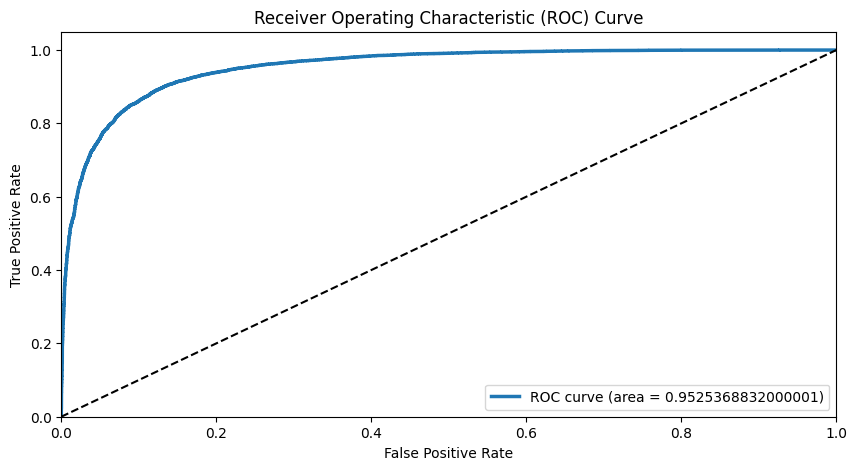

0.9525368832000001

In [ ]:
evaluation.plot_roc(baseline_model, y_test, test_features)

---

## 5. Classifying using K-Means

Let use tfidf features computed in last section as vector inputs for kmeans.

In [ ]:
# TODO Complete in this cell: Train the k-means clustering model using `n_clusters=2`.
# Having the model trained, use it to make predictions on the test dataset.
# Assign the predictions to the variable `kmeans_predictions`, it will be used in the
# following cell to evaluate the model performance.

kmeans = KMeans(n_clusters=2,n_init='auto')

kmeans.fit(train_features,y_train)
print(f"Converged after {kmeans.n_iter_} iterations")
kmeans_predictions = kmeans.predict(test_features)

Converged after 28 iterations


In [ ]:
accuracy, precision, recall, f1_score = evaluation.get_performance(
    [1 - el for el in kmeans_predictions], y_test
)

Model Performance metrics:
------------------------------
Accuracy: 0.51732
Precision: 0.5153144231449388
Recall: 0.5828
F1 Score: 0.546983519165071

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.52      0.45      0.48     12500
           1       0.52      0.58      0.55     12500

    accuracy                           0.52     25000
   macro avg       0.52      0.52      0.52     25000
weighted avg       0.52      0.52      0.52     25000


Prediction Confusion Matrix:
------------------------------
      0     1
0  5648  6852
1  5215  7285


---
## 6. Feature Engineering with Custom Word Embedding

### Tokenize reviews and train your own Word Embedding

You are going to have to train your own word embedding, for this we are going to use the __gensim__ library. The only requirement we ask of you is that the $vector\_size=100$.

[Here](https://radimrehurek.com/gensim/models/word2vec.html) you can read Gensim's Word2Vec documentation so you can train your own embedding, using the review data as a corpus.

As a previous step to training your word embedding you must tokenize the corpus, this may take a bit depending on the size of the dataset and the tokenizer we use, if you want you can try the NLTK tokenizer called `ToktokTokenizer`, which turns out to be a little faster (we hope that this recommendation does not bias your work, try and use the ones you want)

In [ ]:
# TODO Complete in this cell: Tokenize your text corpus and use them to train
# a Word2Vec model.

# TODO: Create and store here the tokenized train and test data.
tokenized_train = [word_tokenize(w) for w in norm_train_reviews]
tokenized_test = [word_tokenize(w) for w in norm_test_reviews]

# TODO: Train your Word2Vec model and assign it to `model_w2v`.
# The output model vector size (w2v_vector_size) is set by default to 100,
# you can change it if you want.
w2v_vector_size = 100
model_w2v = Word2Vec(tokenized_train,vector_size = w2v_vector_size, workers = 4)

In [ ]:
word2vec.w2v_information(model = model_w2v)

w2vec information:
------------------------------
Corpus count: 25000
Trained with: 2977637 words
Vocabulary found: 24042
------------------------------
Example word: movie
[ 7.4820012e-01 -2.9593053e-01  1.4754695e+00  4.4519323e-01
 -1.0276395e+00 -7.1558172e-01  1.3769054e+00  9.7198796e-01
 -3.3965933e-01 -5.9558809e-01  1.3078684e+00  1.7303899e-01
  5.2794254e-01 -2.1553847e-01 -4.8782381e-01  2.4774952e+00
  1.4130926e+00 -3.6367407e-01 -8.4837425e-01 -7.7997106e-01
  1.6046760e+00 -6.4442444e-01  2.9991356e-01  3.4180591e-01
 -6.9866735e-01  1.1954842e+00 -2.5411791e-01  2.5793445e-01
 -4.8671001e-01  7.7285933e-01  4.4294694e-01  2.9126677e-01
  2.0976396e+00 -1.1946275e+00 -6.3894182e-01  1.5424266e+00
  7.4390519e-01 -9.7954404e-03 -2.6719401e-02  7.1423227e-01
  1.7112408e+00  1.7633249e+00  3.4915999e-01 -5.0144279e-01
 -4.9332690e-01  1.0064667e+00 -1.2726940e+00 -1.8921884e+00
  6.5314001e-01 -8.7765223e-01  6.4819580e-01 -7.9821169e-01
 -8.0514807e-01 -3.6712039e-01  2.

In [14]:
# saving the lemmatized word2vec model for later
model_w2v.save('model_w2vec_lem.bin')


### Generate averaged word vector features

Once the embedding has been trained, we must use it. Remember that embedding will convert each word you pass to it into a vector of a given dimension (in our case $vector\_size=100$). So in order to obtain a vector for each review, you must average the vectors of all the words that are part of the same review.

The function must have the following form:
* `vectorizer(corpus, model, num_features=100)`


Where:
* `corpus:` corresponds to the entire dataset, in this way we obtain an average vector for each review, with a single call to the function.
* `model:` is your trained model.
* `num_features:` the dimension of the output vector of your embedding (remember that in our case we set this value to 100).

To do this you must complete the `vectorize` function of the `word2vec.py` module.

In [17]:
# TODO: Make sure you have completed the `vectorizer()` function from
# word2vec.py module.
# You don't need to change this code, just make it run without errors.
w2v_train_features = word2vec.vectorizer(
    corpus=tokenized_train, model=model_w2v, num_features=w2v_vector_size
)
w2v_test_features = word2vec.vectorizer(
    corpus=tokenized_test, model=model_w2v, num_features=w2v_vector_size
)


### Modeling

Finally train a new model, it can be the same one you used before and compare the results you got using BoW/TF-IDF and Word2Vec.

In addition to training the model we ask you to show:

* `Accuracy`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`
* `ROC Curve`
* `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

### Logistic Reggresion model

In [24]:
# TODO Complete in this cell: Train and choose the best model for the task.
# Assign this model to the `best_model` variable.
logreg_model = LogisticRegression()

logreg_model.fit(w2v_train_features, y_train)
model_predictions = logreg_model.predict(w2v_test_features)
evaluation.get_performance(model_predictions,y_test)

Model Performance metrics:
------------------------------
Roc_auc: 0.8475199999999999
Accuracy: 0.84752
Precision: 0.8480769230769231
Recall: 0.84672
F1 Score: 0.8473979183346677

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     12500
           1       0.85      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10604   1896
1   1916  10584


c:\Users\user\Desktop\AnyoneAI\SPR05\sprint05venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.84752, 0.8480769230769231, 0.84672, 0.8473979183346677)

## SVC 
#### support vector classifier




In [23]:
svc_model = SVC() 
svc_model.fit(w2v_train_features, y_train)
svc_predictions =  svc_model.predict(w2v_test_features)
evaluation.get_performance(svc_predictions,y_test)


Model Performance metrics:
------------------------------
Roc_auc: 0.8516400000000001
Accuracy: 0.85164
Precision: 0.8487108290360967
Recall: 0.85584
F1 Score: 0.8522605058753235

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     12500
           1       0.85      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10593   1907
1   1802  10698


(0.85164, 0.8487108290360967, 0.85584, 0.8522605058753235)

## Xgboost

In [22]:
from xgboost import XGBClassifier

xgbm_model = XGBClassifier()
xgbm_model.fit(w2v_train_features, y_train)
xgbm_predictions =  xgbm_model.predict(w2v_test_features)
evaluation.get_performance(xgbm_predictions,y_test)


Model Performance metrics:
------------------------------
Roc_auc: 0.835
Accuracy: 0.835
Precision: 0.834651961959562
Recall: 0.83552
F1 Score: 0.8350857554071883

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.84      0.83      0.83     12500
           1       0.83      0.84      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.84      0.83      0.83     25000
weighted avg       0.84      0.83      0.83     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10431   2069
1   2056  10444


(0.835, 0.834651961959562, 0.83552, 0.8350857554071883)

## Lightgbm tuned

In [25]:
params = { 
    'learning_rate': [0.01, 0.1, 0.05],
    'boosting_type': ['dart'],
    'objective': ['binary'],
    'metric':['auc','binary_logloss'],
    'num_leaves':[31,50,70,90],
    'max_depth':[-1,5,7,9,12],
    'n_estimators': [500,700]
    }
cv = KFold(n_splits=5, shuffle=True, random_state=42)
randomsearch_lgbm = RandomizedSearchCV(
    estimator= LGBMClassifier(), 
    param_distributions= params,
    n_jobs=-1, random_state = 42,
    cv = cv,n_iter=30)
randomsearch_lgbm.fit(w2v_train_features, y_train)

with open('lgbm_model_rscv.pkl','wb') as file:
    pickle.dump(randomsearch_lgbm.best_estimator_,file)

[LightGBM] [Info] Number of positive: 12500, number of negative: 12500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 25000, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [26]:
with open('lgbm_model_rscv.pkl','rb') as file:
    randomsearch_lgbm = pickle.load(file)

lgbm_predictions =  randomsearch_lgbm.predict(w2v_test_features)
evaluation.get_performance(lgbm_predictions,y_test)

Model Performance metrics:
------------------------------
Roc_auc: 0.8425200000000002
Accuracy: 0.84252
Precision: 0.8412369490714912
Recall: 0.8444
F1 Score: 0.8428155068471274

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10508   1992
1   1945  10555


(0.84252, 0.8412369490714912, 0.8444, 0.8428155068471274)

## Logistic reggresion tuned


In [34]:
params = {
    'C': [0.0001,0.001,0.01,0.1,1,1.5,2],
    'max_iter': [500]
}

kf = KFold(n_splits=6, shuffle=True, random_state=5)
log_tuned_model = GridSearchCV(
    LogisticRegression(),
    param_grid=params,
    n_jobs= -1,
    cv=kf
    )
log_tuned_model.fit(w2v_train_features, y_train)

with open('log_tuned_model.pkl','wb') as file:
    pickle.dump(log_tuned_model.best_estimator_,file)

In [35]:
log_pred = log_tuned_model.predict(w2v_test_features)
evaluation.get_performance(log_pred,y_test)

Model Performance metrics:
------------------------------
Roc_auc: 0.8475999999999999
Accuracy: 0.8476
Precision: 0.8484921398780879
Recall: 0.84632
F1 Score: 0.8474046779878244

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     12500
           1       0.85      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10611   1889
1   1921  10579


(0.8476, 0.8484921398780879, 0.84632, 0.8474046779878244)

## 7. Predict data

- Take your best model
- Take `test data` (i.e. the dataset after doing the preprocessing and feature engineering part)
- Run the data through your model and save the predictions on the `positive` column in the `test` DataFrame (yeah that we've loaded at the very beginning of this notebook).
- You will have to use that model to fill values in the positive column using the model predictions
- Save the modified version of the DataFrame with the name (`dataset/movies_review_predict_aai.csv`) and don't forget to submit it alongside the rest of this sprint project code.

Let's say your best model is called `logistic_word2vec`, then your code should be exactly this:

```python
    from src import config
    from pathlib import Path
    DATASET_TEST_PREDICT = str(Path(config.DATASET_ROOT_PATH) / "movies_review_predict_aai.csv")
    test_preds = logistic_word2vec.predict_proba(w2v_test_features)[:, 1]
    test["positive"] = test_preds
    test.to_csv(DATASET_TEST_PREDICT, index=False)
```

In [ ]:
# TODO


---
### OPTIONAL:

In our case, we train a word embedding from scratch, which is very good at an educational level, but when applying it to a real problem, we need a lot of data (which is not the case with our problem). Therefore, we invite you to investigate and use one of the `pre-trained Word2Vec models`.

If you look for the `Pretrained models` section in this [link](https://radimrehurek.com/gensim/models/word2vec.html), you will find information about the models that Gensim owns.

In [4]:
# bring the normalized corpus and tokenize
with open('norm_train_reviews_lem.pkl','rb') as f:
    norm_train_reviews = pickle.load(f)
with open('norm_test_reviews_lem.pkl','rb') as f:
    norm_test_reviews = pickle.load(f)
    
tokenized_train = [word_tokenize(w) for w in norm_train_reviews]
tokenized_test = [word_tokenize(w) for w in norm_test_reviews]

### Analyze impact of emojis

hipothesis: emojis like :), :( are relevant defining the sentiment of a tweet, and this is being supresed by the special_char_removal.


first test: check the frequency of appearence of emojis in the corpus:

In [5]:
# normalize without removing special chars
norm_train_reviews = text_normalizer.normalize_corpus(X_train, stopwords=stop_words,text_stemming=True,special_char_removal=False)
norm_test_reviews = text_normalizer.normalize_corpus(X_test, stopwords=stop_words,text_stemming=True,special_char_removal=False)

c:\Users\user\Desktop\AnyoneAI\SPR05\assignment\src\text_normalizer.py:39: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tagremover = BeautifulSoup(text,"html.parser")


In [24]:
# check first the presence of emojis in the data set 
# search for the main emoji :)
emoji_buscar = [' :)',':)',':) ',' :) ' ]
contador = 0
for tweet in norm_train_reviews:
    for emoji in emoji_buscar:
        contador += tweet.count(emoji)
print(f'the emoji :) appears {contador} times in the tweets')
# the hypothesis was false.

the emoji :) appears 0 times in the tweets


### Vectorize corpus using pretrained model

#### models avaible

In [15]:
import gensim.downloader

# look which models we have avaible
for model in list(gensim.downloader.info()['models'].keys()):
    print(model)

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [16]:
# download model
glove_vectors = gensim.downloader.load('glove-twitter-200')
print(glove_vectors.vector_size)
print(glove_vectors.most_similar(positive=['king','woman'],negative=['man']))

200
[('queen', 0.6820898056030273), ('prince', 0.5875527262687683), ('princess', 0.5620489120483398), ('royal', 0.5522865056991577), ('mother', 0.5362966656684875), ('elizabeth', 0.5142496228218079), ('lady', 0.5010437369346619), ('lion', 0.4998807907104492), ('women', 0.4985955059528351), ('’s', 0.4935073256492615)]


#### vectorizing using the pretrained embeddings

In [17]:
glv_train_features = word2vec.vectorizer(
    corpus=tokenized_train, model=glove_vectors, num_features=glove_vectors.vector_size
)
glv_test_features = word2vec.vectorizer(
    corpus=tokenized_test, model=glove_vectors, num_features=glove_vectors.vector_size
)

#### testing models

In [18]:
svc_model2 = SVC() 
svc_model2.fit(glv_train_features, y_train)
svc_predictions2 =  svc_model2.predict(glv_test_features)
evaluation.get_performance(svc_predictions2,y_test)

Model Performance metrics:
------------------------------
Roc_auc: 0.82512
Accuracy: 0.82512
Precision: 0.8267931810871663
Recall: 0.82256
F1 Score: 0.8246711581649021

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.82      0.83      0.83     12500
           1       0.83      0.82      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10346   2154
1   2218  10282


(0.82512, 0.8267931810871663, 0.82256, 0.8246711581649021)

In [32]:
params = {
    'C': np.linspace(0.0001,0.1,30),
    'max_iter': [500]
}

kf = KFold(n_splits=6, shuffle=True, random_state=5)
log_tuned_model2 = GridSearchCV(
    LogisticRegression(),
    param_grid=params,
    n_jobs= -1,
    cv=kf
    )
log_tuned_model2.fit(glv_train_features, y_train)

log_tuned2_predictions =  log_tuned_model2.predict(glv_test_features)
evaluation.get_performance(log_tuned2_predictions,y_test)


Model Performance metrics:
------------------------------
Roc_auc: 0.8180799999999999
Accuracy: 0.81808
Precision: 0.8234097933951521
Recall: 0.80984
F1 Score: 0.8165685246430587

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.81      0.83      0.82     12500
           1       0.82      0.81      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10329   2171
1   2377  10123


(0.81808, 0.8234097933951521, 0.80984, 0.8165685246430587)

## Recurrent neural network RNN

In [5]:
# let's find out how many words would be cut off with a fixed shape
lens = []
for tweet in tokenized_train:
    lens.append(len(tweet))
    
df_lens = pd.DataFrame(lens)
df_lens.describe()

,0
count,25000.000000
mean,119.105480
std,90.258277
min,4.000000
25%,63.000000
50%,88.000000
75%,145.000000
max,1419.000000


In [6]:
max_features = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

# Input for variable-length sequences of integers
inputs = Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(64))(x)
# Add a classifier
outputs = Dense(1, activation="sigmoid")(x) # many to one
rnn_model = Model(inputs, outputs)
rnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,757,761
Trainable params: 2,757,761
Non-train

#### Transform the dataset



##### get the vocabulary with indexes

In [7]:
tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(norm_train_reviews)

# Ver el vocabulario y asignación de números
word_index = tokenizer.word_index
print("Vocabulary:", word_index)

Vocabulary: {'<OOV>': 1, 'movie': 2, 'film': 3, 'one': 4, 'see': 5, 'make': 6, 'like': 7, 'good': 8, 'well': 9, 'get': 10, 'time': 11, 'would': 12, 'character': 13, 'go': 14, 'watch': 15, 'bad': 16, 'story': 17, 'even': 18, 'really': 19, 'think': 20, 'show': 21, 'scene': 22, 'great': 23, 'look': 24, 'much': 25, 'say': 26, 'could': 27, 'know': 28, 'people': 29, 'also': 30, 'first': 31, 'give': 32, 'way': 33, 'take': 34, 'play': 35, 'love': 36, 'come': 37, 'thing': 38, 'find': 39, 'end': 40, 'man': 41, 'life': 42, 'seem': 43, 'work': 44, 'plot': 45, 'two': 46, 'actor': 47, 'year': 48, 'many': 49, 'want': 50, 'never': 51, 'little': 52, 'try': 53, 'ever': 54, 'still': 55, 'feel': 56, 'old': 57, 'part': 58, 'something': 59, 'back': 60, 'director': 61, 'use': 62, 'lot': 63, 'real': 64, 'performance': 65, 'though': 66, 'acting': 67, 'funny': 68, 'woman': 69, 'new': 70, 'star': 71, 'another': 72, 'guy': 73, 'role': 74, 'nothing': 75, 'big': 76, 'act': 77, 'actually': 78, 'young': 79, 'point': 

##### transform the dataset to sequences and preprocess

In [8]:
sequences_train = tokenizer.texts_to_sequences(norm_train_reviews)
sequences_test = tokenizer.texts_to_sequences(norm_test_reviews)
print(sequences_train[1])
X_train_seq = keras.preprocessing.sequence.pad_sequences(sequences_train)
X_test_seq = keras.preprocessing.sequence.pad_sequences(sequences_test)

[60, 4160, 4417, 2102, 4418, 1, 678, 4161, 165, 405, 264, 257, 3, 617, 22, 22, 725, 1001, 5641, 6621, 1, 98, 469, 6966, 1, 123, 44, 31, 11, 5641, 4626, 1132, 162, 18, 1210, 1048, 5473, 27, 173, 2953, 1, 1, 13495, 4417, 1001, 15617, 2139, 973, 144, 7521, 47, 2483, 4036, 4418, 9, 334, 24, 8, 464, 2918, 10175, 4458, 550, 2459, 16486, 74, 1204, 45, 270, 72, 257, 34, 4584, 16487, 1032, 1315, 3137, 3, 35, 18, 4672, 98, 22, 96, 57, 1617, 500, 4, 295, 18, 725, 106]


#### Train the model

In [9]:
rnn_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='model.{epoch:02d}-{val_loss:.2f}.h5',
    save_best_only=True,  # Set to True to save only the best model based on validation loss
    save_weights_only=False,  # Set to True to save only the model weights, not the entire model
    monitor='val_loss',  # Monitor validation loss for saving the best model
    mode='min',  # Mode for monitoring ('min' means save the model when the monitored quantity is at its minimum)
    verbose=1  # Set to 1 to display messages about model saving
)
rnn_model.fit(X_train_seq, y_train, batch_size=32, epochs=3, validation_data=(X_test_seq, y_test),
              callbacks=[checkpoint_callback])

Epoch 1/3
782/782 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 0.8379
Epoch 1: val_loss improved from inf to 0.37101, saving model to model.01-0.37.h5
782/782 [==============================] - 1626s 2s/step - loss: 0.3697 - accuracy: 0.8379 - val_loss: 0.3710 - val_accuracy: 0.8455
Epoch 2/3
782/782 [==============================] - ETA: 0s - loss: 0.1997 - accuracy: 0.9274
Epoch 2: val_loss did not improve from 0.37101
782/782 [==============================] - 1647s 2s/step - loss: 0.1997 - accuracy: 0.9274 - val_loss: 0.3922 - val_accuracy: 0.8338
Epoch 3/3
782/782 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9571
Epoch 3: val_loss did not improve from 0.37101
782/782 [==============================] - 1662s 2s/step - loss: 0.1221 - accuracy: 0.9571 - val_loss: 0.4248 - val_accuracy: 0.8485


In [31]:
rnn_predictions = rnn_model.predict(X_test_seq)
rnn_predictions = np.where(rnn_predictions>0.5,1,0).reshape(-1,)
evaluation.get_performance(rnn_predictions,y_test)


782/782 [==============================] - 276s 353ms/step
Model Performance metrics:
------------------------------
Roc_auc: 0.84852
Accuracy: 0.84852
Precision: 0.8344721689059501
Recall: 0.86952
F1 Score: 0.8516356513222332

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.86      0.83      0.85     12500
           1       0.83      0.87      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10344   2156
1   1631  10869


(0.84852, 0.8344721689059501, 0.86952, 0.8516356513222332)

# Conclusion


In [1]:
np.linspace(0.0001,1,40)

NameError: name 'np' is not defined

In [ ]:
baseline_model = LogisticRegression()

baseline_model.fit(train_features, y_train)
model_predictions = baseline_model.predict(test_features)

params = {
    'C': np.linspace(0.001),
    'max_iter': [500]
}

kf = KFold(n_splits=6, shuffle=True, random_state=5)
log_tuned_model = RandomizedSearchCV(
    LogisticRegression(),
    param_grid=params,
    n_jobs= -1,
    cv=kf
    )
log_tuned_model.fit(w2v_train_features, y_train)

with open('log_tuned_model.pkl','wb') as file:
    pickle.dump(log_tuned_model.best_estimator_,file)